# Learning: Lake Detection with DINOv3

This notebook will teach you step by step how to:
1. Load your satellite image and manual lake mask
2. Cut the image into small patches
3. Use DINOv3 to analyze each patch
4. Compare with your manual mask
5. Create a lake detection model

## Step 1: Setup and Load Data

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
from transformers import pipeline
from huggingface_hub import login

# Login to HuggingFace (you already have this)
login(token="my-login-token")

In [69]:
# Load your satellite image and mask
image_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_testclip.tif"
mask_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/lake_mask_testclip.tif"

# Read with rasterio for geospatial data
with rasterio.open(image_path) as src:
    image = src.read()  # Shape: (channels, height, width)
    image = np.transpose(image, (1, 2, 0))  # Change to (height, width, channels)
    
with rasterio.open(mask_path) as src:
    mask = src.read(1)  # Read first band

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Unique values in mask: {np.unique(mask)}")

Image shape: (657, 653, 4)
Mask shape: (657, 653)
Unique values in mask: [0 1]


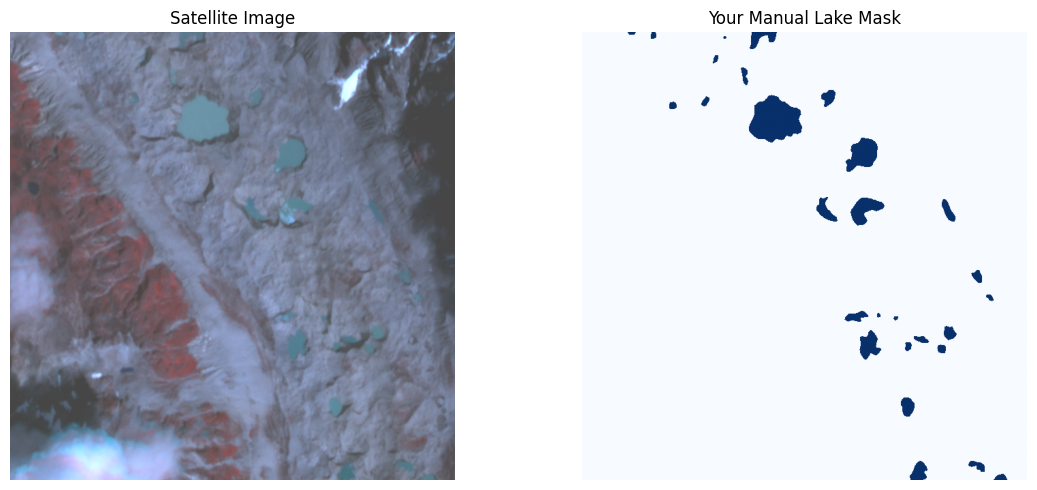

In [70]:
# Visualize your data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Show original image (first 3 bands as RGB)
axes[0].imshow(image[:,:,:3])
axes[0].set_title('Satellite Image')
axes[0].axis('off')

# Show your manual lake mask
axes[1].imshow(mask, cmap='Blues')
axes[1].set_title('Your Manual Lake Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 2: Create Small Patches

We'll cut your big image into small squares. Each square will be analyzed separately.

In [73]:
def create_patches(image, mask, patch_size=224, max_patches=1000):
    """
    Cut image into small squares for learning
    
    Args:
        image: Your satellite image
        mask: Your manual lake mask  
        patch_size: Size of each square (224 works well for vision models)
        max_patches: Limit patches for learning (your image might be huge!)
    """
    
    patches = []
    patch_masks = []
    positions = []
    
    height, width = image.shape[:2]
    
    # Sample patches randomly to avoid too many
    patch_count = 0
    
    for y in range(0, height-patch_size, patch_size//2):  # Overlap patches
        for x in range(0, width-patch_size, patch_size//2):
            if patch_count >= max_patches:
                break
                
            # Extract image patch
            img_patch = image[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            
            # Skip if patch is too small
            if img_patch.shape[0] == patch_size and img_patch.shape[1] == patch_size:
                patches.append(img_patch)
                patch_masks.append(mask_patch)
                positions.append((y, x))
                patch_count += 1
        
        if patch_count >= max_patches:
            break
    
    return patches, patch_masks, positions

# Create patches from your data
patches, patch_masks, positions = create_patches(image, mask, patch_size=224, max_patches=1000)

print(f"Created {len(patches)} patches for learning")
print(f"Each patch is {patches[0].shape}")

Created 16 patches for learning
Each patch is (224, 224, 4)


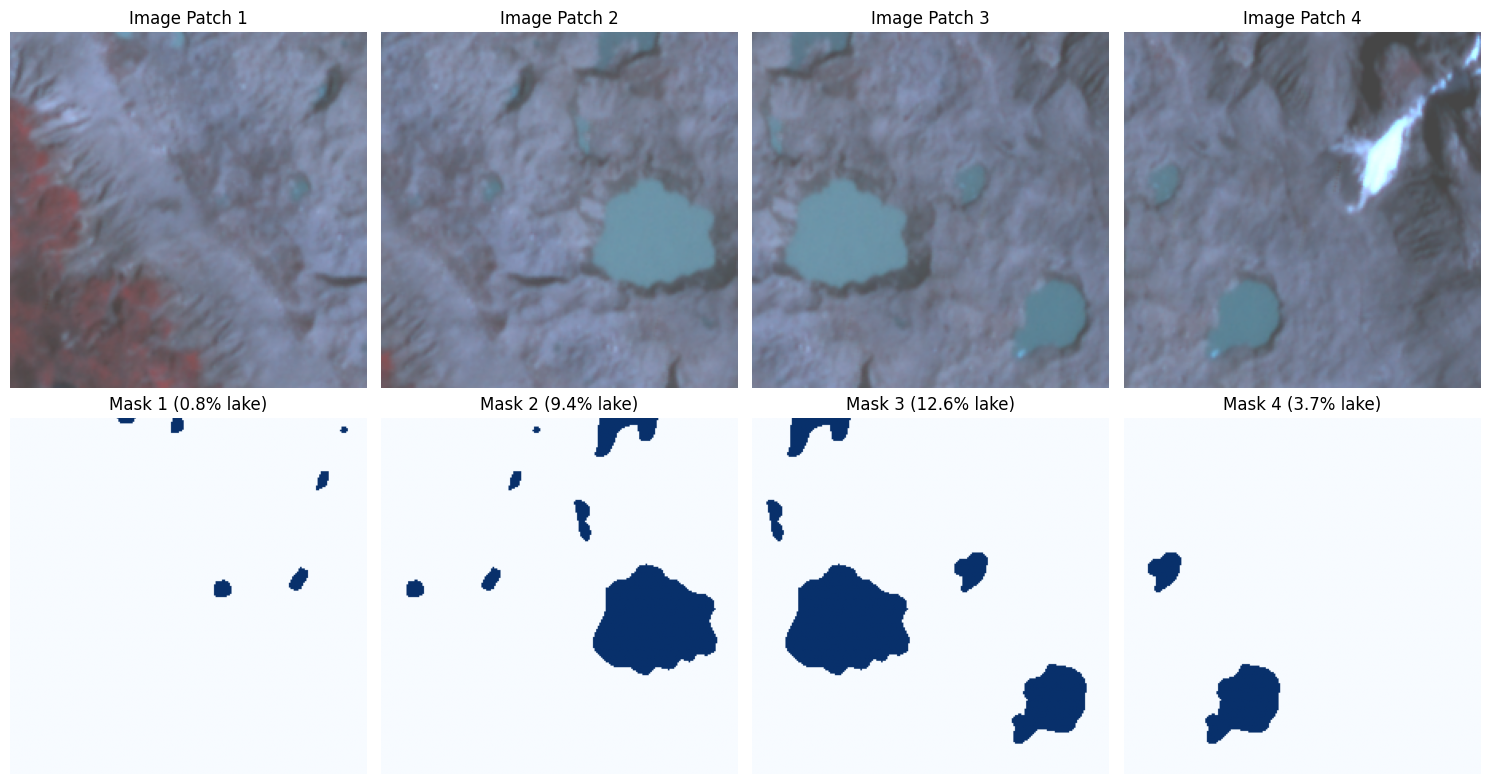

In [74]:
# Let's look at some example patches
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i in range(4):
    # Show image patch
    axes[0, i].imshow(patches[i][:,:,:3])  # RGB channels
    axes[0, i].set_title(f'Image Patch {i+1}')
    axes[0, i].axis('off')
    
    # Show corresponding mask patch
    axes[1, i].imshow(patch_masks[i], cmap='Blues')
    
    # Calculate how much lake is in this patch
    lake_percentage = (patch_masks[i] > 0).mean() * 100
    axes[1, i].set_title(f'Mask {i+1} ({lake_percentage:.1f}% lake)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Step 3: Use DINOv3 Satellite Model

Now we'll use the DINOv3 model trained on satellite data to analyze each patch.

In [75]:
# # Load the satellite-trained DINOv3 model
# feature_extractor = pipeline(
#     model="facebook/dinov3-vit7b16-pretrain-sat493m",  # Satellite version!
#     task="image-feature-extraction",
# )

# print("Loaded DINOv3 satellite model!")

feature_extractor = pipeline(
    model = "facebook/dinov3-vitb16-pretrain-lvd1689m",
    task = "image-feature-extraction",
)



Device set to use cpu


In [81]:
# Extract features from each patch
patch_features = []
patch_labels = []  # Lake or not lake

print("Analyzing patches with DINOv3...")

for i, (patch, mask_patch) in enumerate(zip(patches[:10], patch_masks[:10])):  # Start with just 10
    # Convert to RGB (first 3 channels only)
    patch_rgb = patch[:,:,:3]  # Take only RGB channels
    patch_pil = Image.fromarray(patch_rgb.astype('uint8'))
    
    # Get features from DINOv3
    features = feature_extractor(patch_pil)
    patch_features.append(features[0])
    
    # Create label: is this patch mostly lake?
    lake_percentage = (mask_patch > 0).mean()
    is_lake = lake_percentage > 0.01  # Lower threshold: 1% lake = "lake patch"
    patch_labels.append(is_lake)
    
    print(f"Patch {i+1}: {lake_percentage:.2f} lake → Label: {is_lake}")

print(f"\nExtracted features from {len(patch_features)} patches")
print(f"Feature vector size: {len(patch_features[0])}")

# Show how many of each class we have
lake_count = sum(patch_labels)
print(f"Result: {lake_count} lake patches, {len(patch_labels)-lake_count} non-lake patches")

Analyzing patches with DINOv3...
Patch 1: 0.01 lake → Label: False
Patch 2: 0.09 lake → Label: True
Patch 3: 0.13 lake → Label: True
Patch 4: 0.04 lake → Label: True
Patch 5: 0.00 lake → Label: False
Patch 6: 0.06 lake → Label: True
Patch 7: 0.12 lake → Label: True
Patch 8: 0.07 lake → Label: True
Patch 9: 0.00 lake → Label: False
Patch 10: 0.00 lake → Label: False

Extracted features from 10 patches
Feature vector size: 201
Result: 6 lake patches, 4 non-lake patches


In [82]:
# Debug: Let's see what the features look like (without printing huge arrays)
print("=== DEBUGGING FEATURES ===")
print(f"Number of patches: {len(patch_features)}")
print(f"Type of patch_features: {type(patch_features)}")
print(f"Type of first feature: {type(patch_features[0])}")

if len(patch_features) > 0:
    first_feature = patch_features[0]
    feature_array = np.array(first_feature)
    print(f"First feature shape: {feature_array.shape}")
    print(f"First feature dtype: {feature_array.dtype}")
    print(f"Number of dimensions: {feature_array.ndim}")
    
    # Show just the size, not the content
    if isinstance(first_feature, list):
        print(f"It's a list with {len(first_feature)} elements")

print("=========================")

=== DEBUGGING FEATURES ===
Number of patches: 10
Type of patch_features: <class 'list'>
Type of first feature: <class 'list'>
First feature shape: (201, 768)
First feature dtype: float64
Number of dimensions: 2
It's a list with 201 elements


In [83]:
# Convert to arrays for machine learning
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Properly flatten the 2D features to 1D
X = []
for feature in patch_features:
    feature_array = np.array(feature)
    flattened = feature_array.flatten()  # Convert (201, 768) to (154368,)
    X.append(flattened)

X = np.array(X)  # Shape should be (10, 154368)
y = np.array(patch_labels)    # Your manual labels (lake/not lake)

print(f"Training data shape: {X.shape}")
print(f"Labels: {sum(y)} lake patches, {len(y)-sum(y)} non-lake patches")

# Train a simple classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X, y)

# Test on the same data (just for learning)
predictions = classifier.predict(X)
accuracy = accuracy_score(y, predictions)

print(f"\nClassifier accuracy: {accuracy:.2f}")
print("\nDetailed results:")
print(classification_report(y, predictions, target_names=['Not Lake', 'Lake']))

Training data shape: (10, 154368)
Labels: 6 lake patches, 4 non-lake patches

Classifier accuracy: 1.00

Detailed results:
              precision    recall  f1-score   support

    Not Lake       1.00      1.00      1.00         4
        Lake       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



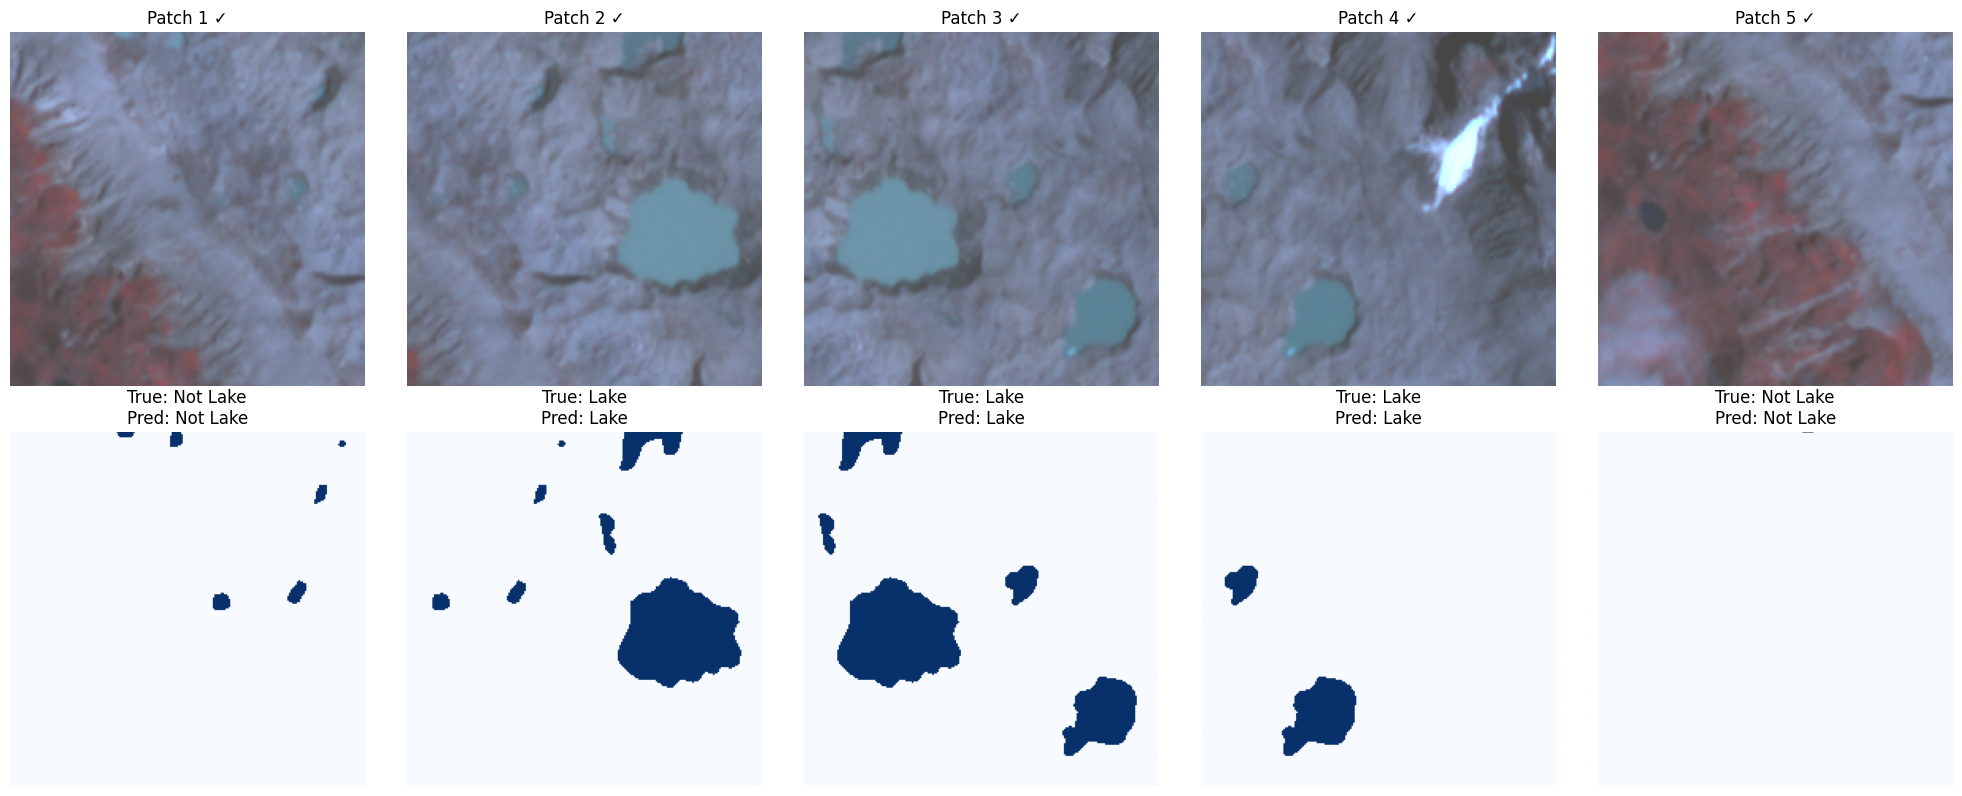

In [84]:
# Let's see which patches the model got right/wrong
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(min(5, len(patches))):
    # Show image
    axes[0, i].imshow(patches[i][:,:,:3])
    
    true_label = "Lake" if patch_labels[i] else "Not Lake"
    pred_label = "Lake" if predictions[i] else "Not Lake"
    correct = "✓" if patch_labels[i] == predictions[i] else "✗"
    
    axes[0, i].set_title(f'Patch {i+1} {correct}')
    axes[0, i].axis('off')
    
    # Show mask
    axes[1, i].imshow(patch_masks[i], cmap='Blues')
    axes[1, i].set_title(f'True: {true_label}\nPred: {pred_label}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# vusualize patches mapped back

In [85]:
# pixel level mask?

Creating pixel-level mask with stride 8...
  Processed 50 patches...
  Processed 100 patches...
  Processed 150 patches...
  Processed 200 patches...
  Processed 250 patches...
  Processed 300 patches...
  Processed 350 patches...
  Processed 400 patches...
  Processed 450 patches...
  Processed 500 patches...
  Processed 550 patches...
  Processed 600 patches...
  Processed 650 patches...
  Processed 700 patches...
  Processed 750 patches...
  Processed 800 patches...
  Processed 850 patches...
  Processed 900 patches...
  Processed 950 patches...
  Processed 1000 patches...
  Processed 1050 patches...
  Processed 1100 patches...
  Processed 1150 patches...
  Processed 1200 patches...
  Processed 1250 patches...
  Processed 1300 patches...
  Processed 1350 patches...
  Processed 1400 patches...
  Processed 1450 patches...
  Processed 1500 patches...
  Processed 1550 patches...
  Processed 1600 patches...
  Processed 1650 patches...
  Processed 1700 patches...
  Processed 1750 patches.

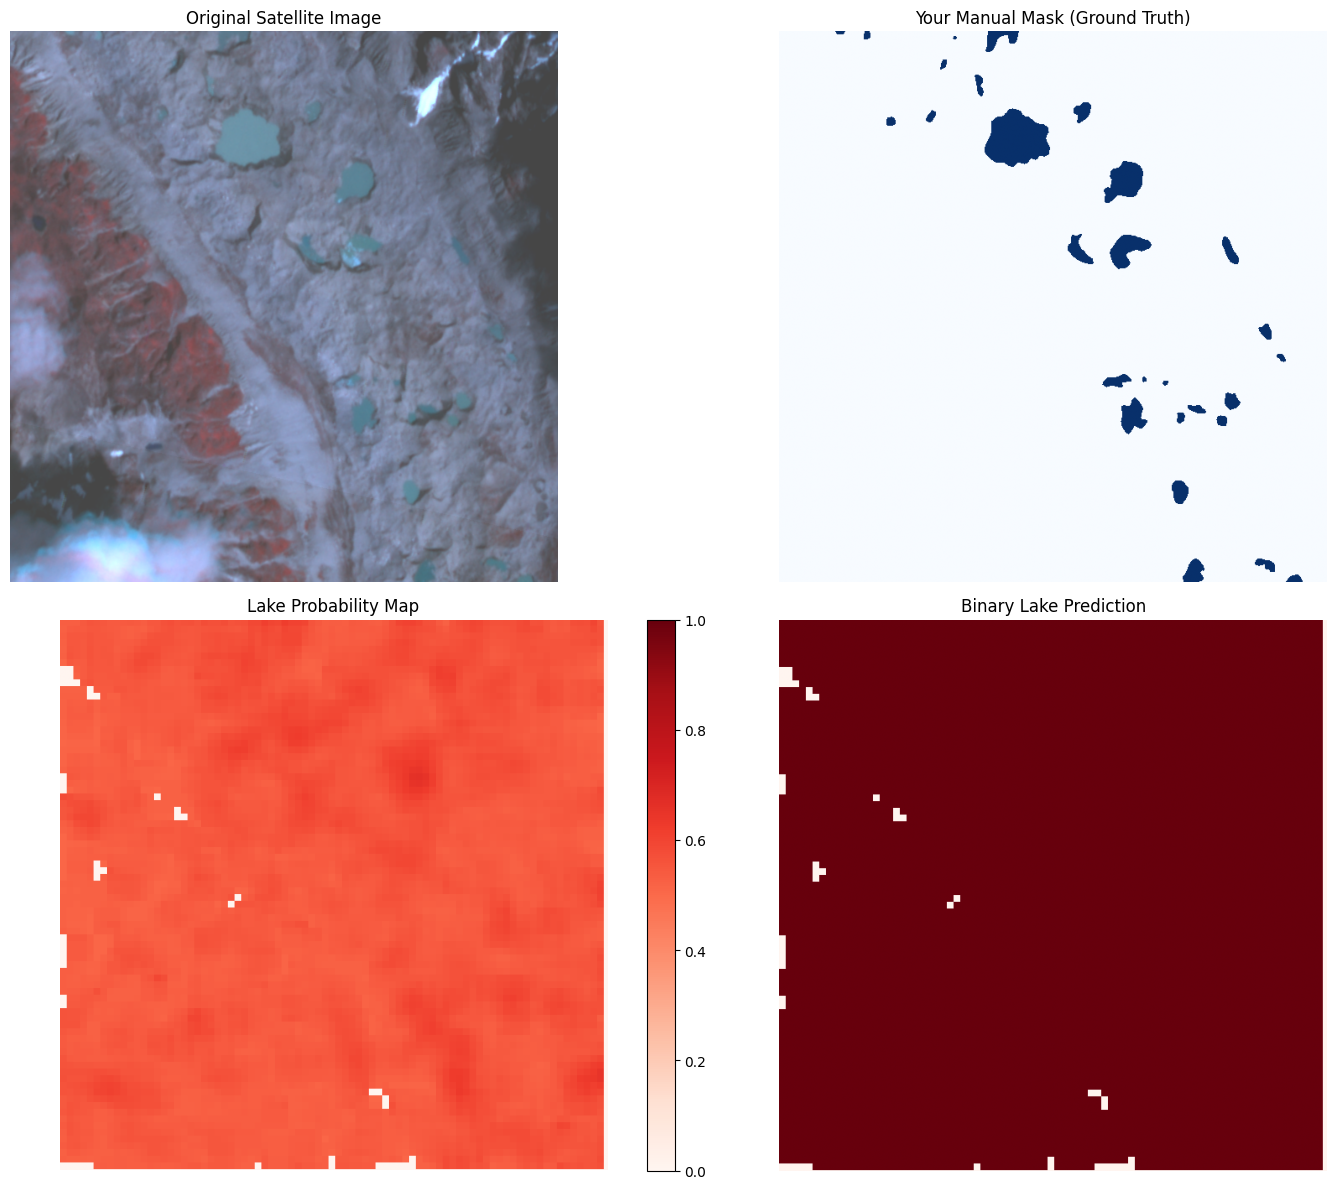

\nPixel-Level Results:
Manual lake pixels: 12,082
Predicted lake pixels: 421,952
Overlapping pixels: 12,043
Recall: 99.7%
Precision: 2.9%


In [88]:
# Step 6: Create Pixel-Level Lake Mask

def create_pixel_level_mask(classifier, image, patch_size=32, stride=8):
    """
    Create pixel-level mask using sliding window approach
    stride = how much to move each step (smaller = more precise but slower)
    """
    height, width = image.shape[:2]
    predicted_mask = np.zeros((height, width), dtype=float)
    count_mask = np.zeros((height, width), dtype=int)  # Count overlaps
    
    print(f"Creating pixel-level mask with stride {stride}...")
    patches_processed = 0
    
    # Slide window across image
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            # Extract patch
            patch = image[y:y+patch_size, x:x+patch_size, :3]  # RGB only
            patch_pil = Image.fromarray(patch.astype('uint8'))
            
            # Get DINOv3 features
            features = feature_extractor(patch_pil)
            feature_array = np.array(features[0]).flatten()
            
            # Predict if this patch contains lake
            prediction = classifier.predict([feature_array])[0]
            probability = classifier.predict_proba([feature_array])[0][1]  # Lake probability
            
            # Add to mask (weighted by probability)
            if prediction:
                predicted_mask[y:y+patch_size, x:x+patch_size] += probability
                count_mask[y:y+patch_size, x:x+patch_size] += 1
            
            patches_processed += 1
            if patches_processed % 50 == 0:
                print(f"  Processed {patches_processed} patches...")
    
    # Average overlapping predictions
    predicted_mask = np.divide(predicted_mask, count_mask, 
                              out=np.zeros_like(predicted_mask), 
                              where=count_mask!=0)
    
    # Threshold to binary mask
    binary_mask = predicted_mask > 0.3  # Adjust threshold as needed
    
    return predicted_mask, binary_mask

# Create pixel-level mask (this will take a few minutes)
probability_mask, binary_mask = create_pixel_level_mask(classifier, image, 
                                                       patch_size=32, stride=8)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original image
axes[0,0].imshow(image[:,:,:3])
axes[0,0].set_title('Original Satellite Image')
axes[0,0].axis('off')

# Your manual mask
axes[0,1].imshow(mask, cmap='Blues')
axes[0,1].set_title('Your Manual Mask (Ground Truth)')
axes[0,1].axis('off')

# Probability map
im1 = axes[1,0].imshow(probability_mask, cmap='Reds', vmin=0, vmax=1)
axes[1,0].set_title('Lake Probability Map')
axes[1,0].axis('off')
plt.colorbar(im1, ax=axes[1,0], fraction=0.046)

# Binary prediction
axes[1,1].imshow(binary_mask, cmap='Reds')
axes[1,1].set_title('Binary Lake Prediction')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

# Calculate accuracy
overlap = np.logical_and(mask > 0, binary_mask > 0).sum()
manual_lake_pixels = (mask > 0).sum()
predicted_lake_pixels = (binary_mask > 0).sum()

print(f"nPixel-Level Results:")
print(f"Manual lake pixels: {manual_lake_pixels:,}")
print(f"Predicted lake pixels: {predicted_lake_pixels:,}")
print(f"Overlapping pixels: {overlap:,}")
if manual_lake_pixels > 0:
    recall = overlap / manual_lake_pixels
    print(f"Recall: {recall:.1%}")
if predicted_lake_pixels > 0:
    precision = overlap / predicted_lake_pixels  
    print(f"Precision: {precision:.1%}")